In [1]:
import os 
import torch 
import matplotlib 
import numpy as np  
import pandas as pd 
import seaborn as sns 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score 
from scipy.interpolate import UnivariateSpline
from torchvision import datasets, models, transforms, utils
from sklearn.preprocessing import StandardScaler

In /packages/parallel_studio_xe_2020/intelpython3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /packages/parallel_studio_xe_2020/intelpython3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /packages/parallel_studio_xe_2020/intelpython3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /packages/parallel_studio_xe_2020/intelpython3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will b

In [2]:
data_dir        = 'patches/img_0_padded'
num_workers     = 4
data_transforms = transforms.Compose([transforms.Resize([11,11]),
                                      transforms.ToTensor()])
device          = torch.device("cpu")#cuda" if torch.cuda.is_available() else "cpu")

In [3]:
image_dataset   = datasets.ImageFolder(os.path.join(data_dir),data_transforms)
dataloader      = torch.utils.data.DataLoader(image_dataset,num_workers=num_workers,batch_size=len(image_dataset))
images,labels   = next(iter(dataloader))

images = images.to(device, torch.uint8)

In [4]:
images = images.reshape(len(images),-1)
images = images.cpu().numpy() 
images = StandardScaler().fit_transform(images)

In [5]:
clusters=range(4,20) 

summed_square_distance=[]
calinski_score=[]

for i in clusters: 
    kmeans=KMeans(n_clusters=i,init='random',precompute_distances=True,random_state=1)
    kmeans=kmeans.fit(images)
    summed_square_distance.append(kmeans.inertia_)
    calinski_score.append(calinski_harabasz_score(images,kmeans.labels_))

In [6]:
#2nd derivative of elbow curve to find optimal number of clusters 
spline    = UnivariateSpline(clusters,summed_square_distance)
spline_d2 = spline.derivative(n=2) 

In [7]:
d2_list = list(spline_d2(clusters))
idx_max = max(range(len(d2_list)),key=d2_list.__getitem__)
n_clusters=idx_max + min(clusters)

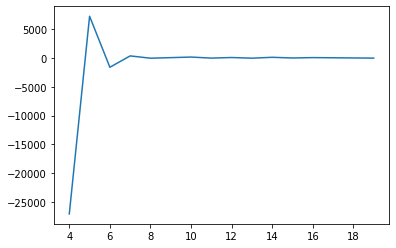

In [8]:
plt.figure() 
plt.plot(clusters,spline_d2(clusters))
plt.show() 

In [9]:
print(n_clusters)
model = KMeans(n_clusters=n_clusters, random_state=0)
model.fit(images)
Y = model.labels_ 

5


<Figure size 432x288 with 0 Axes>

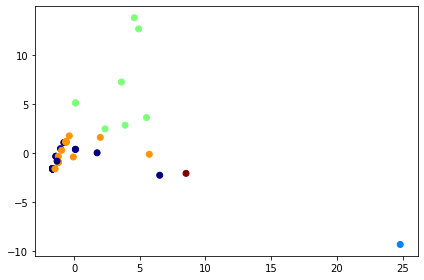

In [10]:
#PCA to 2D 
pca           = PCA(n_components=2)
pca_transform = pca.fit_transform(images)

plt.figure()
fig=plt.figure()
ax=fig.add_subplot(111)
i=0
pca_holder = pd.DataFrame(columns=['pca0','pca1','label'])
pca_holder['pca0']   = pca_transform[:,0]
pca_holder['pca1']   = pca_transform[:,1]
pca_holder['labels'] = Y 
unique_labels = set(pca_holder['labels']) 
plt.scatter(pca_transform[:,0],pca_transform[:,1], c=Y,cmap=plt.cm.jet)
plt.tight_layout() 
plt.savefig('pca_plot.png')